In [1]:
import os
spark_version = 'spark-3.5.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,443 kB]
Get:14 http://archive.ubuntu.com/ubunt

In [35]:
#Import dependencies
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from google.colab import drive
drive.mount('/content/drive')

# Import Keras Dependencies
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
 # Import findspark and initialize.
import findspark
findspark.init()

In [4]:
 # Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("weatherclassification").getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [6]:
# Load in data
from pyspark import SparkFiles
url = 'https://weatherclassification.s3.amazonaws.com/weather_classification_data.csv'
spark.sparkContext.addFile(url)
print(SparkFiles.getRootDirectory())

spark_df = spark.read.csv(SparkFiles.get("weather_classification_data.csv"), sep=",", header=True, inferSchema=True)
spark_df.show()

/tmp/spark-a7837355-80e6-4a39-a35d-57e2ff37cf33/userFiles-64bc3fe3-e52a-47cf-8174-3f7b17c5a249
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|Temperature|Humidity|Wind Speed|Precipitation (%)|  Cloud Cover|Atmospheric Pressure|UV Index|Season|Visibility (km)|Location|Weather Type|
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|         14|      73|       9.5|               82|partly cloudy|             1010.82|       2|Winter|            3.5|  inland|       Rainy|
|         39|      96|       8.5|               71|partly cloudy|             1011.43|       7|Spring|           10.0|  inland|      Cloudy|
|         30|      64|       7.0|               16|        clear|             1018.72|       5|Spring|            5.5|mountain|       Sunny|
|         38|      83|       1.5|               82|        

In [7]:
# Convert PySpark DataFrame to pandas DataFrame
weather_df = spark_df.toPandas()
weather_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14,73,9.5,82,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39,96,8.5,71,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30,64,7.0,16,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38,83,1.5,82,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27,74,17.0,66,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [8]:
#Remove weather type
weather_data_no_type = weather_df.drop('Weather Type', axis=1)

In [9]:
# Convert categorical data to numeric with 'get_dummies'
weather_data_no_type = pd.get_dummies(weather_data_no_type).astype(int)
weather_data_no_type.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14,73,9,82,1010,2,3,0,0,0,1,0,0,0,1,0,1,0
1,39,96,8,71,1011,7,10,0,0,0,1,0,1,0,0,0,1,0
2,30,64,7,16,1018,5,5,1,0,0,0,0,1,0,0,0,0,1
3,38,83,1,82,1026,7,1,1,0,0,0,0,1,0,0,1,0,0
4,27,74,17,66,990,1,2,0,0,1,0,0,0,0,1,0,0,1


In [10]:
# Split our preprocessed data into our features and target arrays
X = weather_data_no_type
y = weather_df['Weather Type']

# Use LabelEncoder to convert categorical weather type labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = 4
y_one_hot = to_categorical(y_encoded, num_classes)

encoded_labels = label_encoder.classes_
encoded_labels = label_encoder.transform(label_encoder.classes_)
label_mapping = dict(zip(encoded_labels, label_encoder.classes_))
print(f"Labels: {label_mapping}")

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, random_state=1)

Labels: {0: 'Cloudy', 1: 'Rainy', 2: 'Snowy', 3: 'Sunny'}


In [11]:
# Normalize Data
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Create function for model creation
def gen_model(units, activation_functions, input_dim, optimizer):
  # Define the deep learning model
  nn_model = tf.keras.models.Sequential()
  nn_model.add(tf.keras.Input(shape=(input_dim,)))
  for i in range(len(units)):
    nn_model.add(tf.keras.layers.Dense(units=units[i], activation=activation_functions[i]))
  nn_model.add(tf.keras.layers.Dense(units=4, activation="softmax"))

  # Compile the Sequential model together and customize metrics
  nn_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return nn_model

In [18]:
# Model 1  Simpler architecture (Neurons network [64, 32, 16, 8])
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_1 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_1.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_1.evaluate(X_test,y_test,verbose=2)

print(f"Model 1 (Simpler architecture) Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5142 - loss: 1.1525 - val_accuracy: 0.8783 - val_loss: 0.6772
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8578 - loss: 0.6558 - val_accuracy: 0.8717 - val_loss: 0.5299
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8734 - loss: 0.4397 - val_accuracy: 0.8838 - val_loss: 0.3558
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8900 - loss: 0.3232 - val_accuracy: 0.8919 - val_loss: 0.2978
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8902 - loss: 0.3046 - val_accuracy: 0.8869 - val_loss: 0.2992
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8990 - loss: 0.2826 - val_accuracy: 0.8980 - val_loss: 0.2813
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8970 - loss: 0.2898 - val_accuracy: 0.8889 - val_loss: 0.2917
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8996 - loss: 0.2713 - val_accuracy: 0.

In [19]:
# Make predictions using testing data
predictions = nn_model_1.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model 1 (Simpler architecture)')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model (Simpler architecture)")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion Matrix Model 1 (Simpler architecture)
[[745  26  61  10]
 [ 44 728  72   2]
 [ 12   3 800   5]
 [ 35   9  42 706]]
Classification Report Model (Simpler architecture)
              precision    recall  f1-score   support

      Cloudy       0.89      0.88      0.89       842
       Rainy       0.95      0.86      0.90       846
       Snowy       0.82      0.98      0.89       820
       Sunny       0.98      0.89      0.93       792

    accuracy                           0.90      3300
   macro avg       0.91      0.90      0.90      3300
weighted avg       0.91      0.90      0.90      3300



In [20]:
# Get training and validation loss and accuracy values
nn_model_1_losses = fit_model.history['loss']
nn_model_1_accuracy = fit_model.history['accuracy']
nn_model_1_val_losses = fit_model.history['val_loss']
nn_model_1_val_accuracy = fit_model.history['val_accuracy']

In [21]:
# Model 2 Balanced architecture (Neurons [128, 64, 32, 16])
units = [128, 64, 32, 16]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_2 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_2.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_2.evaluate(X_test,y_test,verbose=2)

print(f"Model 2 (Balanced architecture) Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6086 - loss: 0.9316 - val_accuracy: 0.8818 - val_loss: 0.4008
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8696 - loss: 0.4010 - val_accuracy: 0.8838 - val_loss: 0.3337
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8899 - loss: 0.3232 - val_accuracy: 0.8843 - val_loss: 0.3149
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8965 - loss: 0.2934 - val_accuracy: 0.8990 - val_loss: 0.2675
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9036 - loss: 0.2674 - val_accuracy: 0.8975 - val_loss: 0.2621
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8987 - loss: 0.2673 - val_accuracy: 0.9005 - val_loss: 0.2553
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9012 - loss: 0.2637 - val_accuracy: 0.8965 - val_loss: 0.2621
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9030 - loss: 0.2543 - val_accuracy: 0.

In [22]:
# Make predictions using testing data
predictions = nn_model_2.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model 2 (Balanced architecture)')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model 2 (Balanced architecture)")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix Model 2 (Balanced architecture)
[[757  38  17  30]
 [ 65 747  18  16]
 [ 14  17 770  19]
 [ 35  21  13 723]]
Classification Report Model 2 (Balanced architecture)
              precision    recall  f1-score   support

      Cloudy       0.87      0.90      0.88       842
       Rainy       0.91      0.88      0.90       846
       Snowy       0.94      0.94      0.94       820
       Sunny       0.92      0.91      0.92       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [23]:
# Get training and validation loss and accuracy values
nn_model_2_losses = fit_model.history['loss']
nn_model_2_accuracy = fit_model.history['accuracy']
nn_model_2_val_losses = fit_model.history['val_loss']
nn_model_2_val_accuracy = fit_model.history['val_accuracy']

In [24]:
# Model 3 Deeper architecture (Neurons [256, 128, 64, 32])
units = [256, 128, 64, 32]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_3 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_3.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_3.evaluate(X_test,y_test,verbose=2)

print(f"Model 3 (Deeper architecture) Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7069 - loss: 0.8079 - val_accuracy: 0.8843 - val_loss: 0.3642
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8821 - loss: 0.3558 - val_accuracy: 0.8889 - val_loss: 0.3080
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8953 - loss: 0.2985 - val_accuracy: 0.9005 - val_loss: 0.2612
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8933 - loss: 0.2765 - val_accuracy: 0.8949 - val_loss: 0.2687
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9026 - loss: 0.2574 - val_accuracy: 0.8970 - val_loss: 0.2603
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9051 - loss: 0.2487 - val_accuracy: 0.9045 - val_loss: 0.2417
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9079 - loss: 0.2469 - val_accuracy: 0.9056 - val_loss: 0.2373
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9031 - loss: 0.2406 - val_accuracy: 0.

In [25]:
# Make predictions using testing data
predictions = nn_model_3.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model 3 (Deeper architecture)')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model 3 (Deeper architecture)")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model 3 (Deeper architecture)
[[742  39  29  32]
 [ 51 738  36  21]
 [ 12  15 775  18]
 [ 29  18  21 724]]
Classification Report Model 3 (Deeper architecture)
              precision    recall  f1-score   support

      Cloudy       0.89      0.88      0.89       842
       Rainy       0.91      0.87      0.89       846
       Snowy       0.90      0.95      0.92       820
       Sunny       0.91      0.91      0.91       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [26]:
# Get training and validation loss and accuracy values
nn_model_3_losses = fit_model.history['loss']
nn_model_3_accuracy = fit_model.history['accuracy']
nn_model_3_val_losses = fit_model.history['val_loss']
nn_model_3_val_accuracy = fit_model.history['val_accuracy']

In [27]:
# Model 4 Inverted Pyramid architecture (Neurons [32, 64, 128, 256])
units = [32, 64, 128, 256]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_4 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_4.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_4.evaluate(X_test,y_test,verbose=2)

print(f"Model 4 (Inverted Pyramid architecture): {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6737 - loss: 0.8490 - val_accuracy: 0.8707 - val_loss: 0.4000
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8661 - loss: 0.3912 - val_accuracy: 0.8828 - val_loss: 0.3406
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8825 - loss: 0.3219 - val_accuracy: 0.8955 - val_loss: 0.2917
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8877 - loss: 0.3005 - val_accuracy: 0.8924 - val_loss: 0.2787
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8908 - loss: 0.2896 - val_accuracy: 0.8960 - val_loss: 0.2618
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9048 - loss: 0.2499 - val_accuracy: 0.9010 - val_loss: 0.2435
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9078 - loss: 0.2498 - val_accuracy: 0.9025 - val_loss: 0.2449
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8986 - loss: 0.2529 - val_accuracy: 0.

In [28]:
# Make predictions using testing data
predictions = nn_model_4.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model 4 (Inverted Pyramid architecture)')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model 4 (Inverted Pyramid architecture)")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Confusion Matrix Model 4 (Inverted Pyramid architecture)
[[748  53  16  25]
 [ 46 754  27  19]
 [ 13  19 768  20]
 [ 41  17  17 717]]
Classification Report Model 4 (Inverted Pyramid architecture)
              precision    recall  f1-score   support

      Cloudy       0.88      0.89      0.89       842
       Rainy       0.89      0.89      0.89       846
       Snowy       0.93      0.94      0.93       820
       Sunny       0.92      0.91      0.91       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [29]:
# Get training and validation loss and accuracy values
nn_model_4_losses = fit_model.history['loss']
nn_model_4_accuracy = fit_model.history['accuracy']
nn_model_4_val_losses = fit_model.history['val_loss']
nn_model_4_val_accuracy = fit_model.history['val_accuracy']

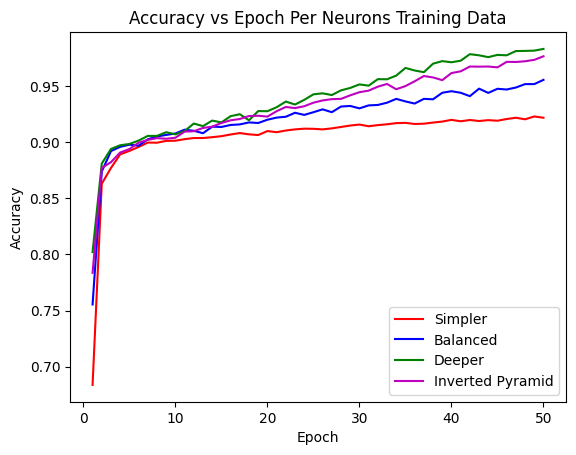

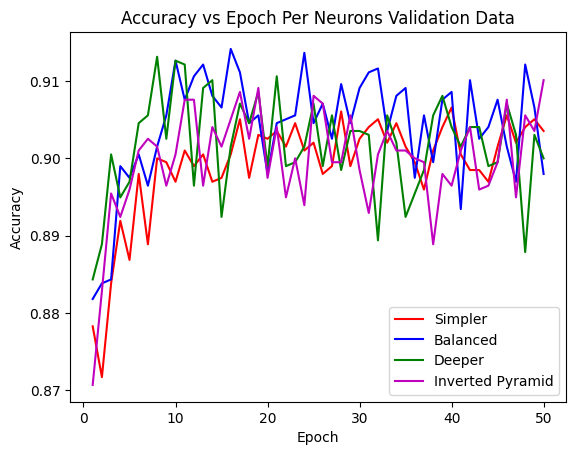

In [40]:
# Plot accuracy for each neural network training and validation data attempts

#nn training accuracy data
epochs = range(1, len(nn_model_1_accuracy) + 1)

plt.plot(epochs, nn_model_1_accuracy, 'r', label = 'Simpler')
plt.plot(epochs, nn_model_2_accuracy, 'b', label = 'Balanced')
plt.plot(epochs, nn_model_3_accuracy, 'g', label = 'Deeper')
plt.plot(epochs, nn_model_4_accuracy, 'm', label = 'Inverted Pyramid')

plt.title('Accuracy vs Epoch Per Neurons Training Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Training Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Training Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Training Data.png', format='png')

plt.show()



#nn validation accuracy data
epochs = range(1, len(nn_model_1_accuracy) + 1)

plt.plot(epochs, nn_model_1_val_accuracy, 'r', label = 'Simpler')
plt.plot(epochs, nn_model_2_val_accuracy, 'b', label = 'Balanced')
plt.plot(epochs, nn_model_3_val_accuracy, 'g', label = 'Deeper')
plt.plot(epochs, nn_model_4_val_accuracy, 'm', label = 'Inverted Pyramid')

plt.title('Accuracy vs Epoch Per Neurons Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Validation Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Validation Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Validation Data.png', format='png')

plt.show()



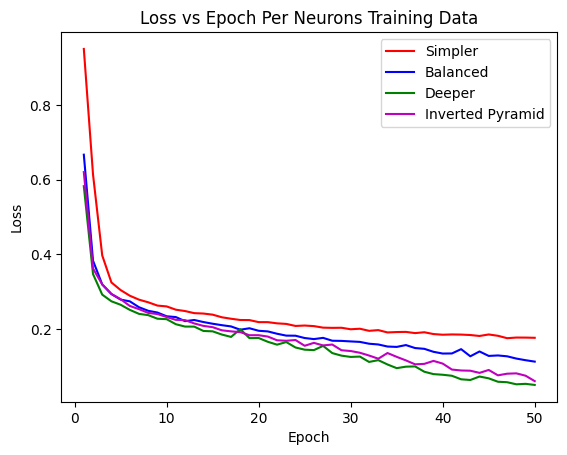

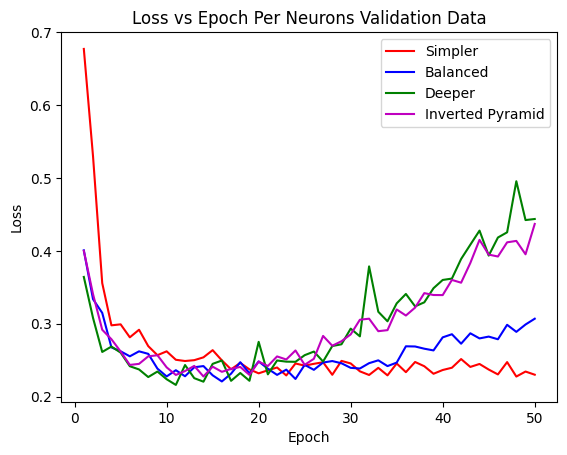

In [42]:
# Plot loss for each neural network training and validation data attempts

#nn training loss data
epochs = range(1, len(nn_model_1_losses) + 1)

plt.plot(epochs, nn_model_1_losses, 'r', label = 'Simpler')
plt.plot(epochs, nn_model_2_losses, 'b', label = 'Balanced')
plt.plot(epochs, nn_model_3_losses, 'g', label = 'Deeper')
plt.plot(epochs, nn_model_4_losses, 'm', label = 'Inverted Pyramid')

plt.title('Loss vs Epoch Per Neurons Training Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Training Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Training Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Training Data.png', format='png')

plt.show()



#nn validation loss data
epochs = range(1, len(nn_model_1_losses) + 1)

plt.plot(epochs, nn_model_1_val_losses, 'r', label = 'Simpler')
plt.plot(epochs, nn_model_2_val_losses, 'b', label = 'Balanced')
plt.plot(epochs, nn_model_3_val_losses, 'g', label = 'Deeper')
plt.plot(epochs, nn_model_4_val_losses, 'm', label = 'Inverted Pyramid')

plt.title('Loss vs Epoch Per Neurons Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Validation Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Validation Data.png')


plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Validation Data.png', format='png')

plt.show()